# Exp15. 프로젝트 : 다양한 OCR 모델 비교하기 (번호판 인식)
- 사람이 문자를 읽으려면 문자가 있다는 것을 1) 인식하고, 인식한 문자를 2) 해독하는 과정을 거치는 것이 일반적이다. 
- 기계도 다르지 않은데, 문자의 존재를 1) Detection하고, 어떤 문자인지 판독하는 2) Recognition으로 나눌 수 있다.  

## 1. Google OCR API

In [1]:
import os
import io
from glob import glob
from google.cloud import vision
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image, ImageDraw

images_path = glob(os.getenv('HOME')+'/aiffel/ocr_python/numberplates/*.jpg')
images_path

['/aiffel/aiffel/ocr_python/numberplates/06.jpg',
 '/aiffel/aiffel/ocr_python/numberplates/05.jpg',
 '/aiffel/aiffel/ocr_python/numberplates/07.jpg',
 '/aiffel/aiffel/ocr_python/numberplates/04.jpg',
 '/aiffel/aiffel/ocr_python/numberplates/00.jpg',
 '/aiffel/aiffel/ocr_python/numberplates/03.jpg',
 '/aiffel/aiffel/ocr_python/numberplates/02.jpg',
 '/aiffel/aiffel/ocr_python/numberplates/08.jpg',
 '/aiffel/aiffel/ocr_python/numberplates/01.jpg']

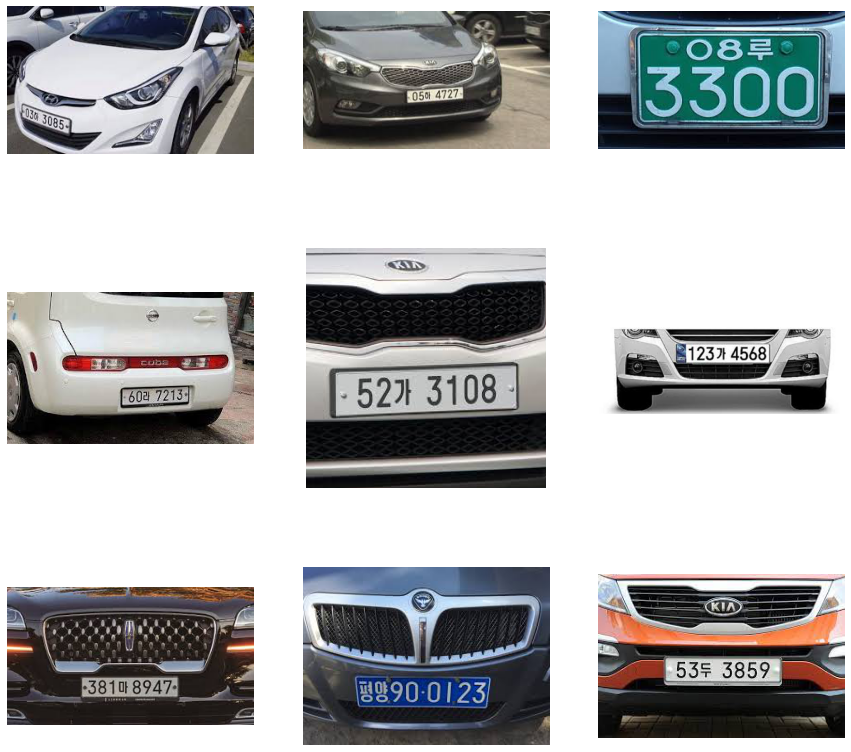

In [2]:
plt.figure(figsize=(15, 15))

for idx, image in enumerate(images_path):
    plt.subplot(3, 3, idx+1)
    im = img.imread(image)
    plt.imshow(im)
    plt.axis('off')

In [3]:
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image

In [4]:
# Google Cloud Vision API 활용
def detect_text(path):
    """Detects text in the file."""
    text_dec = []
    bounds = []
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    s = os.path.splitext(path)
    s = os.path.split(s[0])
    name = s[1]
    
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations

    for text in texts:
        text_dec.append(text.description.replace('\n',''))
        vertices = text.bounding_poly
        bounds.append(vertices)
    
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return name, text_dec, bounds

In [5]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 한다. 
# 클라우드 환경에서는 무시해도 좋다. 
#!ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

ocr_img = []
ocr_dict = {}

# 입력 이미지 경로 지정
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
# path = os.getenv('HOME')+'/aiffel/ocr_python/01.jpg'   

# 위에서 정의한 OCR API 이용 함수를 호출
for path in images_path:
    name, text_dec, bounds = detect_text(path)
    ocr_dict[name] = text_dec
    image = Image.open(path)
    draw_boxes(image, bounds, 'red')
    ocr_img.append(image)

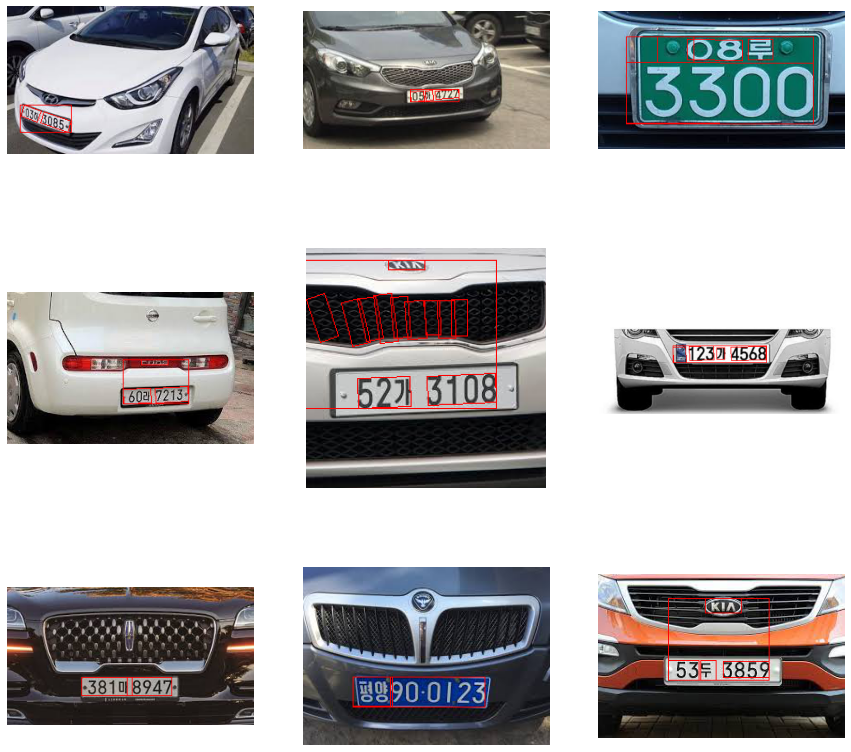

In [6]:
plt.figure(figsize=(15, 15))

for idx, img in enumerate(ocr_img):
    plt.subplot(3, 3, idx+1)
    plt.imshow(img)
    plt.axis('off')

In [7]:
ocr_dict

{'06': ['030 3085-', '030', '3085-'],
 '05': ['05하 4727', '05', '하', '4727'],
 '07': ['©08루3300', '©', '08', '루', '3300'],
 '04': ['Cube602 7213-', 'Cube', '602', '7213-'],
 '00': ['KIA527 31080000000000000000000000000000000000000',
  'KIA',
  '527',
  '3108',
  '0000',
  '0000',
  '0000',
  '0000',
  '0000',
  '0000',
  '0000',
  '00000',
  '0000'],
 '03': ['의123가 4568', '의', '123', '가', '4568'],
 '02': ['3810 8947', '3810', '8947'],
 '08': ['명망90-0123', '명망', '90-0123'],
 '01': ['KIA53두 3859', 'KIA', '53', '두', '3859']}

## 2. Keras-OCR

In [8]:
import keras_ocr

# keras_ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 된다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [9]:
# 테스트에 사용할 이미지
images = [ keras_ocr.tools.read(url) for url in images_path]
predictions = [pipeline.recognize([url]) for url in images_path]

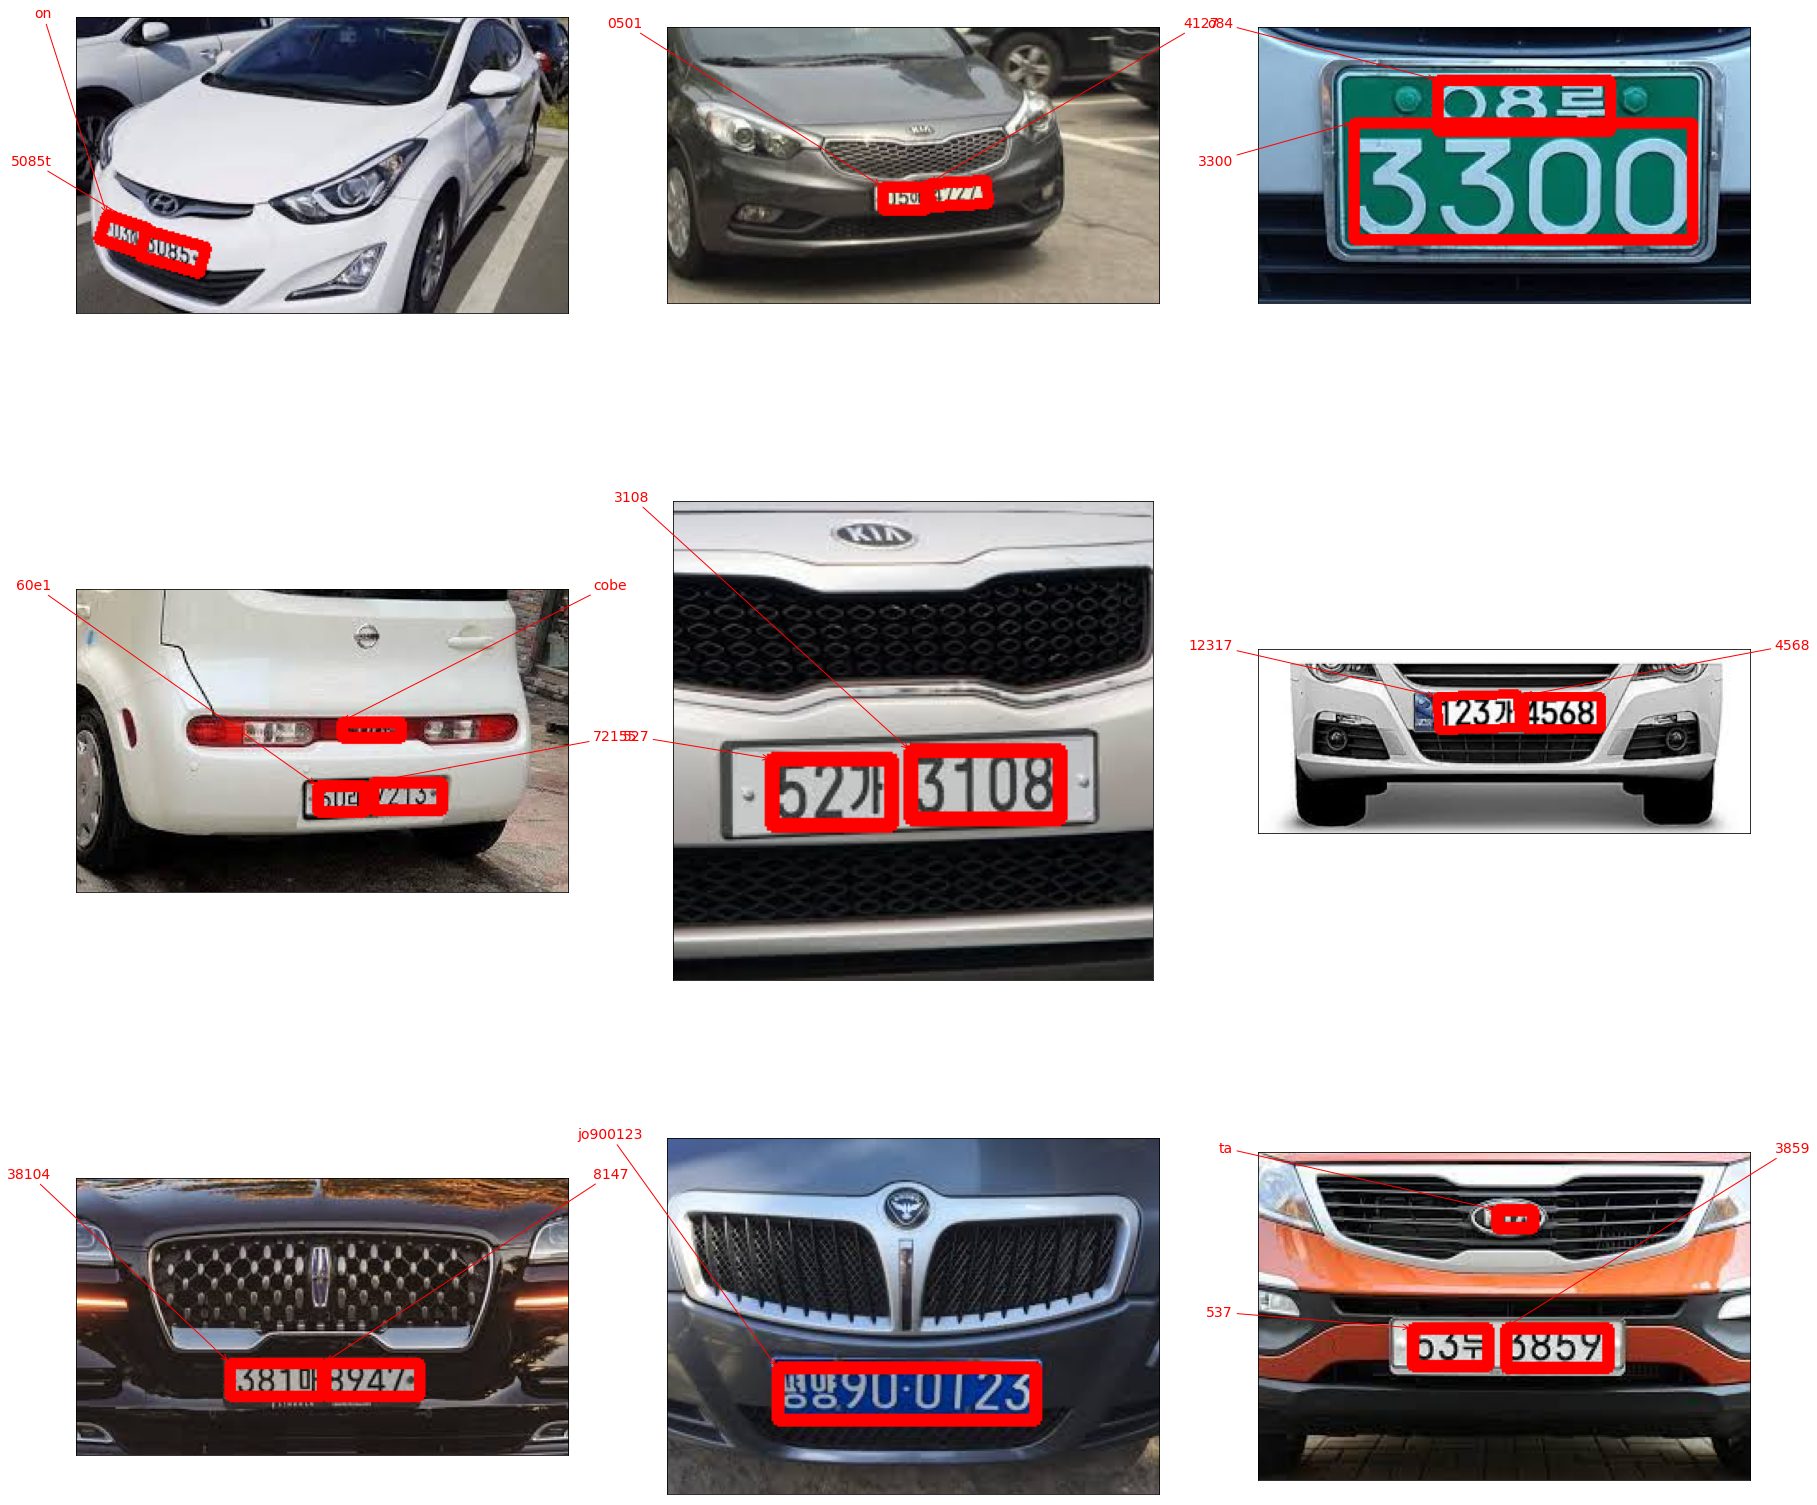

In [10]:
# Plot the predictions
fig, axs = plt.subplots(3, 3, figsize=(30, 30))

for i in range(len(axs)):
    for j in range(len(axs[i])):
        keras_ocr.tools.drawAnnotations(image=images[3*i+j], 
                                    predictions=predictions[3*i+j][0], ax=axs[i,j])

## 3. Tesseract OCR
- 테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 현재는 버전 4와 Tesseract.js 등으로 확장되는 등 많은 곳에서 사용되고 있다.
- 버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116개 국어를 지원하고 있다. 

- `Pytesseract`는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리다. 

In [11]:
#!sudo apt install tesseract-ocr-kor

import pytesseract
from pytesseract import Output

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/numberplates/03.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png


- `crop_word_regions()` 함수는 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴한다. 
- `pytesseract.image_to_data()`를 사용한다. 파이썬에서 편하게 사용하기 위해서 `pytesseract`의 `Output`을 사용해서 결과값의 형식을 딕셔너리 형태로 설정해 주게 된다. 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 갖게 된다. 바운딩 박스를 이용해 이미지의 문자 영역들을 PIL 또는 opencv 라이브러리를 사용해 crop해서 `cropped_image_path_list`에 담아 리턴한다. 

In [12]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

나

기

도

1 23가


전

Done


- 번호판 인식은 원래 사진에서 번호판을 detect하고, detect한 번호판을 OCR로 읽어내는 2-스테이지로 이루어진다고 알고 있었다. 그럼에도, 뭔가 무작정 차량의 raw 이미지를 던져줬을 때 어떤 결과를 보이는지 궁금해서 번호판 데이터를 선택했다. 
- 가장 기대했던 테서렉트가 번호판(특히 한글이 포함된 번호판)을 잘 읽지 못했고 구글 API가 가장 그나마 괜찮은 결과를 보이긴 했으나 역시 번호판을 detect하는 첫 단계 없이 진행했기 때문에 차량의 그물망 같은 그릴 부분을 여러 개의 숫자 0으로 인식한다던가 하는 문제점이 있다. 
- 결국 번호판 인식은 2-스테이지로 이루어져야 한다. 그래서 번호판을 detect한 이후에 각 모듈들의 OCR 성능은 어떨까 궁금해서 이런저런 시도를 해 보았었는데, 그 부분에 대한 코드가 너무 길어져서 노드 제출용으로는 부적절하지 않나 싶어서 조금 더 다듬은 후 개인 프로젝트로 올려볼까 한다. 